<a href="https://colab.research.google.com/github/jbmmbj/m494/blob/main/All_Test_1_INN_Fuchs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Invertible Neural Network Trained on Fuch's Data**

https://github.com/ronak-n-desai/fuchs-ml-v2/blob/main/datasets/Fuchs_Data_Generation_v3.2.ipynb

## Dependencies

In [ ]:
pip install FrEIA

In [2]:
%matplotlib inline
from time import time

import torch
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom, InvertibleSigmoid, AllInOneBlock


device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prepare Fuch's Data

Load Fuch's data

In [3]:
df = pd.read_csv('data_noise0.csv')

Data set size is 25000 divided into 20000 train and 5000 test

In [4]:
def normalize(values, actual_bounds, desired_bounds):
    return [desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0]) / (actual_bounds[1] - actual_bounds[0]) for x in values]

In [5]:
l1 = list(df['Focal_Distance_(um)'])
l2 = list(df['Intensity_(W_cm2)'] * 1e-18)
l3 = list(df['Target_Thickness (um)'])
lx = list(zip(l1, l2, l3))
x = torch.tensor(lx)
x_train = x[:20000]
x_test = x[20000:]

In [6]:
l1 = list(df['Avg_Proton_Energy_(MeV)'])
l2 = list(df['Max_Proton_Energy_(MeV)'])
l3 = list(df['Total_Proton_Energy_(MeV)'] * 1e-7)
ly = list(zip(l1, l2, l3))
y = torch.tensor(ly)
y_train = y[:20000]
y_test = y[20000:]

## Build Network

In [7]:
ndim_tot = 16
ndim_x = 3
ndim_y = 3
ndim_z = 8

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.ReLU(),
                         nn.Linear(512,  c_out))

nodes = [InputNode(ndim_tot, name='input')]

for k in range(8):
    nodes.append(Node(nodes[-1],
                      GLOWCouplingBlock,
                      {'subnet_constructor':subnet_fc, 'clamp':2.0},
                      name=F'coupling_{k}'))
    nodes.append(Node(nodes[-1],
                      PermuteRandom,
                      {'seed':k},
                      name=F'permute_{k}'))

nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False)

## Training

Parameters and Loss Functions

In [15]:
# Training parameters
n_epochs = 100
n_its_per_epoch = 50
batch_size = 400

lr = 1e-3
l2_reg = 2e-5

y_noise_scale = 1e-1
zeros_noise_scale = 5e-2

# Each loss is weighted to make them comparable magnitudes:
lambd_predict = 6.
lambd_latent = 100.
lambd_rev = 400.

pad_x = torch.zeros(batch_size, ndim_tot - ndim_x)
pad_yz = torch.zeros(batch_size, ndim_tot - ndim_y - ndim_z)

trainable_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_parameters, lr=lr, betas=(0.8, 0.9),
                             eps=1e-6, weight_decay=l2_reg)


def MMD_multiscale(x, y):
    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2.*xx
    dyy = ry.t() + ry - 2.*yy
    dxy = rx.t() + ry - 2.*zz

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for a in [0.05, 0.2, 0.9]:
        XX += a**2 * (a**2 + dxx)**-1
        YY += a**2 * (a**2 + dyy)**-1
        XY += a**2 * (a**2 + dxy)**-1

    return torch.mean(XX + YY - 2.*XY)


def fit(input, target):
    return torch.mean((input - target)**2)

loss_backward = MMD_multiscale
loss_latent = MMD_multiscale
loss_fit = fit

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test, y_test),
    batch_size=batch_size, shuffle=True, drop_last=True)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train, y_train),
    batch_size=batch_size, shuffle=True, drop_last=True)

Define training loop

In [16]:
def train(i_epoch=0):
    model.train()

    forward_loss_latent = 0
    forward_loss_fit = 0
    backward_loss_backward = 0
    backward_loss_fit = 0
    total_loss = 0
    it_loss = 0

    l_tot = 0
    batch_idx = 0

    t_start = time()

    loss_factor1 = min(1., 2. * 0.002**(1. - (float(i_epoch*5) / n_epochs)))
    loss_factor2 = min(1., 2. * 0.000002**(1. - (float(i_epoch*5) / n_epochs)))

    for x, y in train_loader:
        batch_idx += 1
        if batch_idx > n_its_per_epoch:
            break

        x, y = x.to(device), y.to(device)

        y_clean = y.clone()
        pad_x = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                ndim_x, device=device)
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)

        y += y_noise_scale * torch.randn(batch_size, ndim_y, dtype=torch.float, device=device)

        x, y = (torch.cat((x, pad_x),  dim=1),
                torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz, y),
                          dim=1))


        optimizer.zero_grad()

        # Forward step:

        output, _ = model(x)

        # Remove zero-padding for latent loss
        y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)

        l1 = lambd_predict * loss_fit(output[:, ndim_z:], y[:, ndim_z:])

        forward_loss_fit += l1.cpu().data.numpy()

        output_block_grad = torch.cat((output[:, :ndim_z],
                                       output[:, -ndim_y:].data), dim=1)

        l2 = lambd_latent * loss_latent(output_block_grad, y_short)

        forward_loss_latent += (l2.cpu().data.numpy())

        l = l1 + l2

        l.backward()

        # Backward step:
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)
        y = y_clean + y_noise_scale * torch.randn(batch_size, ndim_y, device=device)

        orig_z_perturbed = (output.data[:, :ndim_z] + y_noise_scale *
                            torch.randn(batch_size, ndim_z, device=device))
        y_rev = torch.cat((orig_z_perturbed, pad_yz,
                           y), dim=1)
        y_rev_rand = torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz,
                                y), dim=1)

        output_rev, _ = model(y_rev, rev=True)
        output_rev_rand, _ = model(y_rev_rand, rev=True)

        l1_rev = (
            lambd_rev
            * loss_factor1
            * loss_backward(output_rev_rand[:, :ndim_x],
                            x[:, :ndim_x])
        )

        backward_loss_backward += l1_rev.cpu().data.numpy()

        l2_rev = lambd_predict * loss_factor2 * loss_fit(output_rev, x)

        backward_loss_fit += (l2_rev.cpu().data.numpy())

        total_loss += (forward_loss_fit + forward_loss_latent + backward_loss_backward + backward_loss_fit)

        it_loss = np.append(it_loss, total_loss)

        l_rev = l1_rev + l2_rev

        l_rev.backward()

        for p in model.parameters():
            if p.grad is not None:
              p.grad.data.clamp_(-15.00, 15.00)

        optimizer.step()

    return forward_loss_latent / batch_idx, forward_loss_fit / batch_idx, backward_loss_backward / batch_idx, backward_loss_fit / batch_idx, total_loss / batch_idx, it_loss

Training

In [17]:
for param in trainable_parameters:
    param.data = 0.05*torch.randn_like(param)

model.to(device)

N_samp = 200

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]
x_samps_clean = x_samps
y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
y_samps_clean = y_samps
y_samps += y_noise_scale * torch.randn(N_samp, ndim_y)
y_samps = torch.cat([torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z),
                     y_samps], dim=1)
y_samps = y_samps.to(device)

f_loss_latent = 0
fll = 0
f_loss_fit = 0
flf = 0
b_loss_backward = 0
blb = 0
b_loss_fit = 0
blf = 0
t_loss = 0
tl = 0
it_loss = 0
it = 0

try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        fll, flf, blb, blf, tl, it = train(i_epoch)

        f_loss_latent = np.append(f_loss_latent, fll)
        f_loss_fit = np.append(f_loss_fit, flf)
        b_loss_backward = np.append(b_loss_backward, blb)
        b_loss_fit = np.append(b_loss_fit, blf)
        t_loss = np.append(t_loss, tl)
        it_loss = np.append(it_loss, it)

    # Sample the trained model
    rev_x, _ = model(y_samps, rev=True)
    rev_x = rev_x.cpu().data.numpy()

    pred_nrgs, _ = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                              dim=1).to(device))
    pred_nrgs_clean = pred_nrgs.data[:, -ndim_y:]
    rev_x_clean = rev_x[:, :ndim_x]

    pred_nrgs = pred_nrgs.cpu().data.numpy()
    pred_nrgs_clean = pred_nrgs_clean.cpu().data.numpy()

except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining time: {(time()-t_start)/60:.2f} minutes\n")

100%|#########################################| 100/100 [05:17<00:00,  3.17s/it]



Training time: 5.29 minutes



## Loss

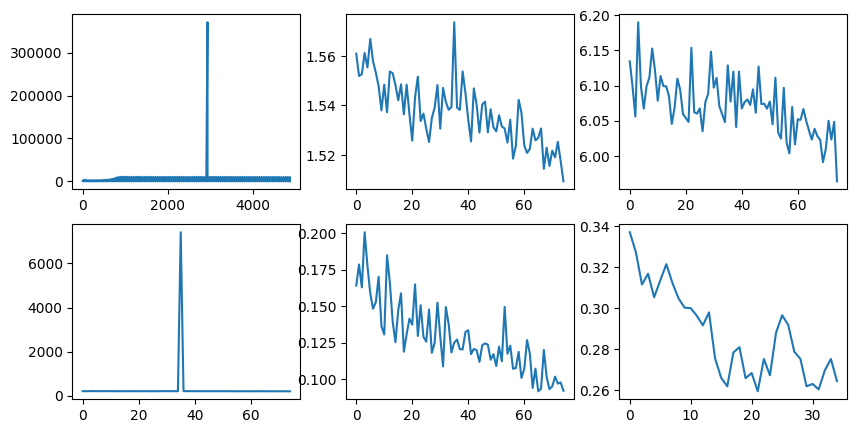

In [21]:
f, axarr = plt.subplots(2, 3, figsize=(10,5))

axarr[0,0].plot(it_loss[125:5000])
axarr[1,0].plot(t_loss[25:100])
axarr[0,1].plot(f_loss_latent[25:100])
axarr[1,1].plot(f_loss_fit[25:100])
axarr[0,2].plot(b_loss_backward[25:100])
axarr[1,2].plot(b_loss_fit[65:100])

In [13]:
# This stop the code from running past this point so that "Run all" can be used
1/0

ZeroDivisionError: division by zero

## Test normalizing direction (laser parameters to proton energies)

## Test generative direction (proton energies to laser parameters)

## Save

Save model

In [22]:
torch.save(model.state_dict(), 't2')

Save losses

In [23]:
np.save('f_loss_latent', f_loss_latent)
np.save('f_loss_fit', f_loss_fit)
np.save('b_loss_backward', b_loss_backward)
np.save('b_loss_fit', b_loss_fit)
np.save('t_loss', t_loss)
np.save('it_loss', it_loss)

Save samples

In [27]:
np.save('rev_x_clean', rev_x_clean)
np.save('pred_nrgs_clean', pred_nrgs_clean)
np.save('x_samps_clean', x_samps_clean)
np.save('y_samps_clean', y_samps_clean)

## Load & Sample

Dependencies

In [ ]:
pip install FrEIA

In [ ]:
%matplotlib inline
from time import time

import torch
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom, InvertibleSigmoid, AllInOneBlock


device = 'cuda' if torch.cuda.is_available() else 'cpu'

Load model

In [ ]:
ndim_tot = 12
ndim_x = 2
ndim_y = 2
ndim_z = 6

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.ReLU(),
                         nn.Linear(512,  c_out))

nodes = [InputNode(ndim_tot, name='input')]

for k in range(8):
    nodes.append(Node(nodes[-1],
                      GLOWCouplingBlock,
                      {'subnet_constructor':subnet_fc, 'clamp':2.0},
                      name=F'coupling_{k}'))
    nodes.append(Node(nodes[-1],
                      PermuteRandom,
                      {'seed':k},
                      name=F'permute_{k}'))

nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False)

model.load_state_dict(torch.load('t1', map_location=torch.device('cpu')))
model.eval()

Load data

In [ ]:
df = pd.read_csv('data_noise0.csv')

l1 = list(df['Focal_Distance_(um)'])
l3 = list(df['Target_Thickness (um)'])
lx = list(zip(l1, l3))
x = torch.tensor(lx)
x_train = x[:20000]
x_test = x[20000:]

l1 = list(df['Avg_Proton_Energy_(MeV)'])
l2 = list(df['Max_Proton_Energy_(MeV)'])
ly = list(zip(l1, l2))
y = torch.tensor(ly)
y_train = y[:20000]
y_test = y[20000:]

batch_size = 400

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test, y_test),
    batch_size=batch_size, shuffle=True, drop_last=True)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train, y_train),
    batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
y_test.shape

Load losses

In [ ]:
#f_loss_latent = np.load('f_loss_latent.npy')
#f_loss_fit = np.load('f_loss_fit.npy')
#b_loss_backward = np.load('b_loss_backward.npy')
#b_loss_fit = np.load('b_loss_fit.npy')
#t_loss = np.load('t_loss.npy')
#it_loss = np.load('it_loss.npy')

Sample model

In [32]:
y_noise_scale = 1e-1
zeros_noise_scale = 5e-2
pad_x = torch.zeros(batch_size, ndim_tot - ndim_x)
pad_yz = torch.zeros(batch_size, ndim_tot - ndim_y - ndim_z)

model.to(device)

N_samp = 4800

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]
x_samps_clean = x_samps
y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
y_samps_clean = y_samps
y_samps += y_noise_scale * torch.randn(N_samp, ndim_y)
y_samps = torch.cat([torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z),
                     y_samps], dim=1)
y_samps = y_samps.to(device)

rev_x, _ = model(y_samps, rev=True)
rev_x = rev_x.cpu().data.numpy()

pred_nrgs, _ = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                          dim=1).to(device))
pred_nrgs_clean = pred_nrgs.data[:, -ndim_y:]
rev_x_clean = rev_x[:, :ndim_x]

pred_nrgs = pred_nrgs.cpu().data.numpy()

## Cross-validation

Prep training set

In [33]:
N_samp = 4800

y_train_samps = y_train[:N_samp]
y_train_samps += y_noise_scale * torch.randn(N_samp, ndim_y)
y_train_samps = torch.cat([torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z),
                     y_train_samps], dim=1)
y_train_samps = y_train_samps.to(device)

rev_x_train, _ = model(y_train_samps, rev=True)
rev_x_train = rev_x_train.cpu().data.numpy()
rev_x_train_clean = rev_x_train[:, :ndim_x]

MSE of training set

In [34]:
A, B = x_train.cpu().data.numpy()[:N_samp,1], rev_x_train_clean[:,1]
mse = ((A - B)**2).mean()
print(mse)

3.4765797


MSE of validation set

In [35]:
A, B = x_samps_clean[:,1].cpu().data.numpy(), rev_x_clean[:,1]
mse = ((A - B)**2).mean()
print(mse)

12.294456
